In [254]:
import pandas as pd
import numpy as np
import missingno as msno
from collections import defaultdict 
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder

### Importar las bases de datos y combinarlas para limpiar ambos datos a la vez

In [255]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['Set'] = 'Train'
test['Set'] = 'Test'

df = pd.concat([train, test])
df.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
Set                0
dtype: int64

<Axes: >

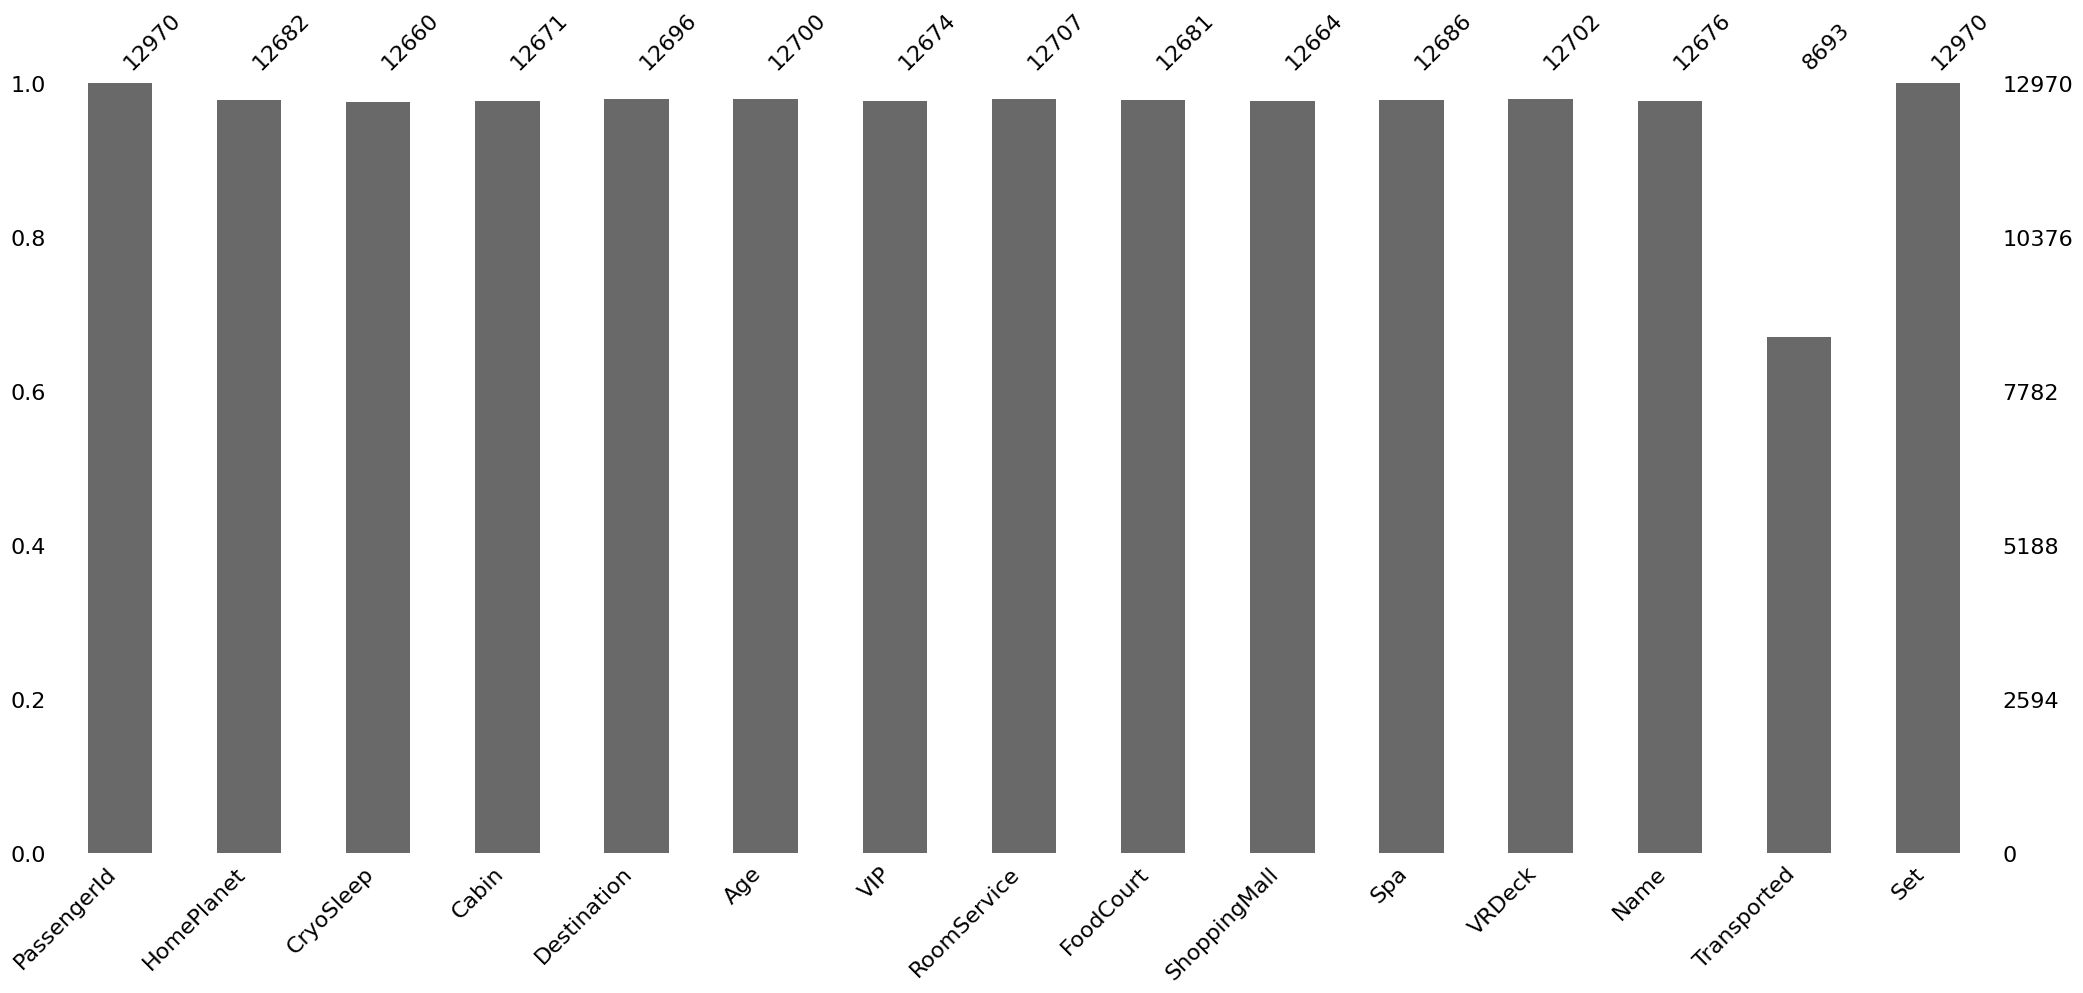

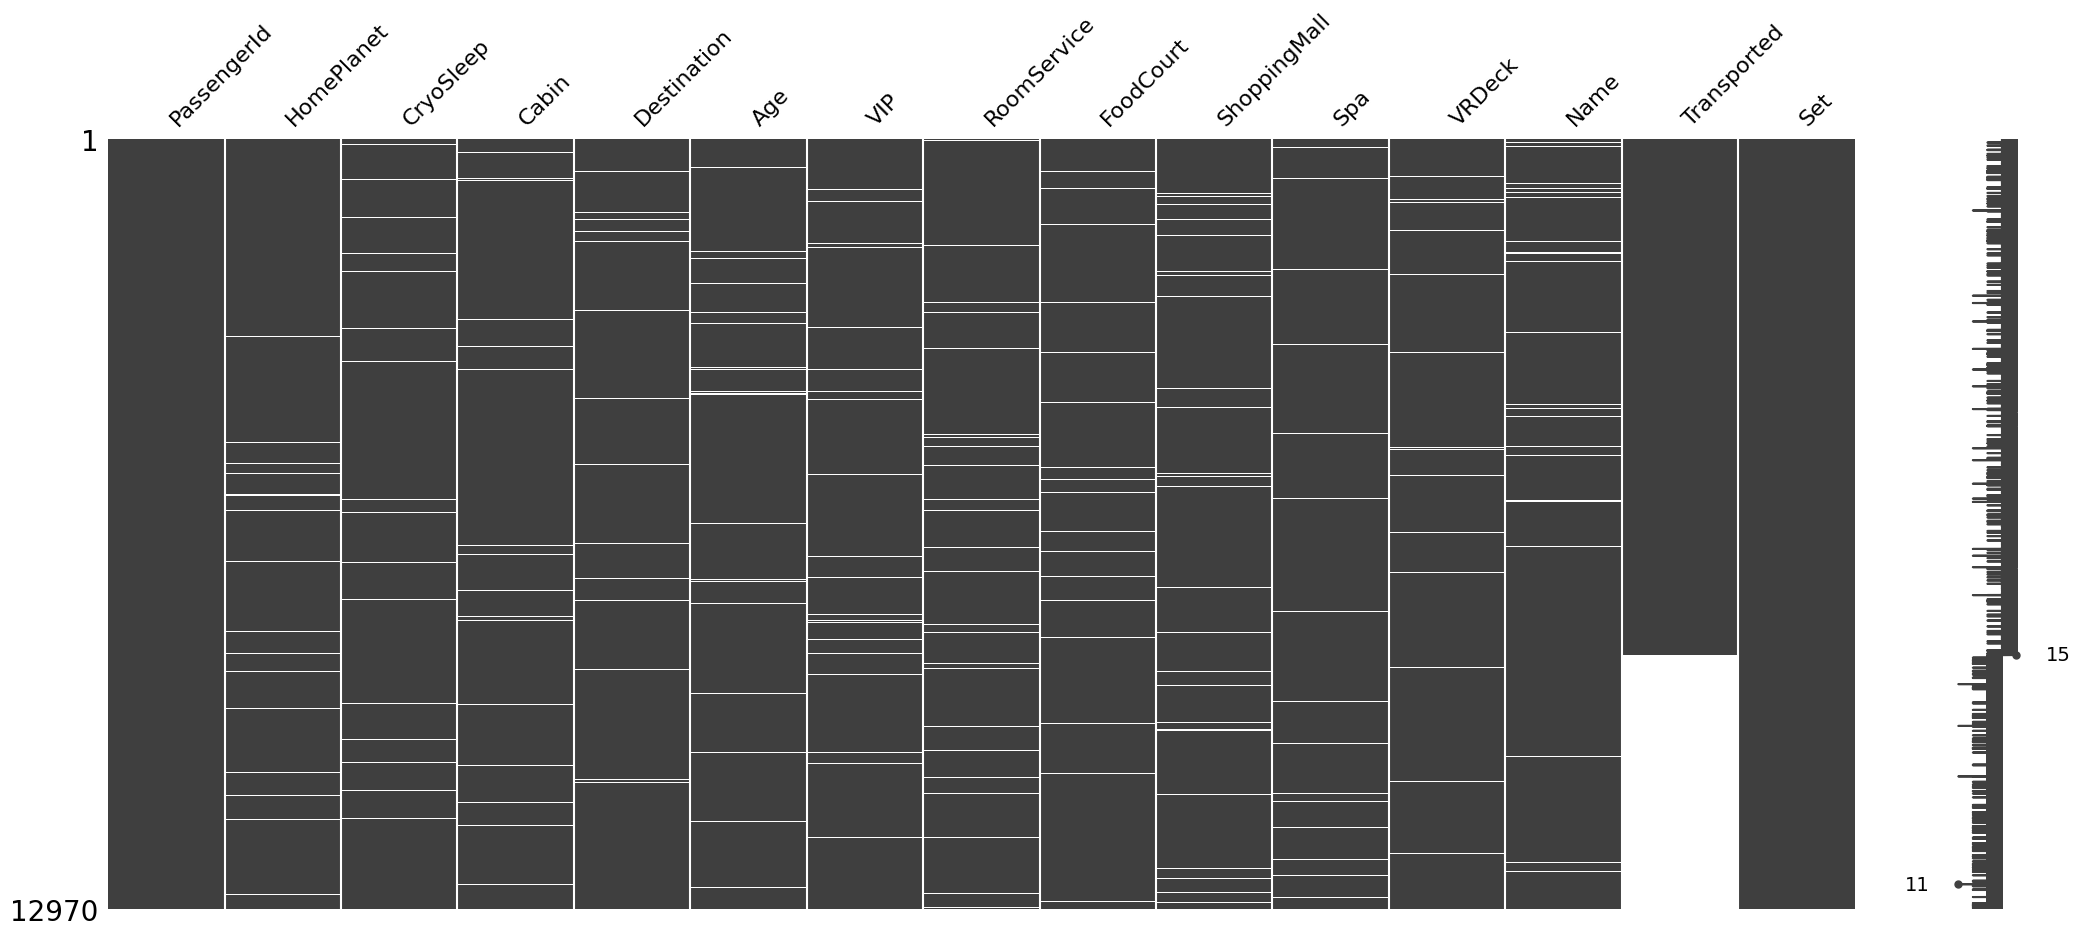

In [256]:
msno.bar(df)
msno.matrix(df)

Encontramos un gran número de datos perdidos en la variable de transported como es esperable dado que hemos unido el df de test que no tiene estos datos incluidos.

Para comenzar a hacer la limpieza se pueden comprobar si se cumplen ciertas constantes. Por ejemplo, comprobar que los pasajeros que están en CryoSleep no van a realizar gastos en la nave. También podemos comprobar si los niños realizan gastos (encontramos que a partir de 12 no pueden hacer cargos probando distintas edades)

In [257]:
df_cryo = df.loc[df['CryoSleep'] == True, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
df_cryo.nunique()

df_age = df.loc[df['Age'] <= 12, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
df_age.nunique()

RoomService     1
FoodCourt       1
ShoppingMall    1
Spa             1
VRDeck          1
dtype: int64

Podemos por tanto recodificarlos a 0 todos los pasajeros en cryosleep y menores de 13 para reducir el número de datos perdidos.
Lo contrario también es cierto, si hay algún gasto en cualquiera de los servicios podemos asumir que (si el pasajero no tiene menos de 13 años) no está en CryoSleep.

Vamos además a crear una variable para facilitar los cálculos y para generar una nueva feature para los modelos, que divida a los pasajeros según hayan hecho algún gasto o ninguno.

In [258]:
condicion_cryo = df['CryoSleep'] == True

df.loc[condicion_cryo & df['RoomService'].isna(), 'RoomService'] = 0
df.loc[condicion_cryo & df['FoodCourt'].isna(), 'FoodCourt'] = 0
df.loc[condicion_cryo & df['ShoppingMall'].isna(), 'ShoppingMall'] = 0
df.loc[condicion_cryo & df['Spa'].isna(), 'Spa'] = 0
df.loc[condicion_cryo & df['VRDeck'].isna(), 'VRDeck'] = 0

condicion_edad = df['Age'] < 13

df.loc[condicion_edad & df['RoomService'].isna(), 'RoomService'] = 0
df.loc[condicion_edad & df['FoodCourt'].isna(), 'FoodCourt'] = 0
df.loc[condicion_edad & df['ShoppingMall'].isna(), 'ShoppingMall'] = 0
df.loc[condicion_edad & df['Spa'].isna(), 'Spa'] = 0
df.loc[condicion_edad & df['VRDeck'].isna(), 'VRDeck'] = 0

df['Gastos'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1, skipna=True)

condicion_gastos = df['Gastos'] > 0
condicion_edad2 = df['Age'] >= 13

df['Algun_Gasto'] = np.where(df['Gastos'] > 0, 1, 0)

df.loc[condicion_gastos & condicion_edad2 & df['CryoSleep'].isna(), 'CryoSleep'] = False

Podemos comprobar si hay gente que no esté en cryosleep, no sea menor de 13 y que no haya realizado gastos, ya que si no encontramos ningún caso también podríamos recodificar dicha variable. En este caso encontramos que si hay personas que cumplen dicha condición por lo que no podemos recodificarla.

In [259]:
df.loc[(df['Age'] >= 13) & (df['Gastos'] == 0) & (df['CryoSleep'] == False)].nunique()

PassengerId     145
HomePlanet        3
CryoSleep         1
Cabin           141
Destination       3
Age              45
VIP               2
RoomService       1
FoodCourt         1
ShoppingMall      1
Spa               1
VRDeck            1
Name            141
Transported       2
Set               2
Gastos            1
Algun_Gasto       1
dtype: int64

Una de las variables que más información nos va a dar para imputar el resto de datos es la información sobre la cabina en la que se encuentra cada pasajero. Para ello, se ha usado el desarrollo que ha hecho el usuario de kaggle Jacob Sultan:
- https://www.kaggle.com/code/jacobsultan/how-to-impute-nearly-every-cabin-correctly

In [260]:
df[['CabinDeck', 'CabinNumber', 'CabinSide']] = df['Cabin'].str.split("/", expand = True)

 Si nos fijamos en la variable de cabina vemos que se divide en tres parámetros, cubierta (letra), cabina (numero), y lado (port y starboard), vamos a separarla en tres columnas para trabajar con ella y ver si podemos reducir aún más el número de datos perdidos utilizando lógica antes de imputar de otras formas.

In [261]:
df[['CabinDeck', 'CabinNumber', 'CabinSide']] = df['Cabin'].str.split("/", expand = True)

Podemos analizar si diferentes cubiertas de cabina pertenecen a diferentes orígenes plantearios.

In [262]:
df.groupby(['CabinDeck', 'HomePlanet']).size().reset_index(name = 'Count')

,CabinDeck,HomePlanet,Count
0,A,Europa,346
1,B,Europa,1124
2,C,Europa,1081
3,D,Europa,296
4,D,Mars,406
5,E,Earth,583
6,E,Europa,197
7,E,Mars,508
8,F,Earth,2426
9,F,Mars,1713


Podemos detenernos en cada una de ellas, pero al ser datos tan numerosos podemos ver la cubierta T como ejemplo (que solo presenta 10 valores)

Parece que en algunos casos si se cumple está condición mientras que para otros es posible que haya otras variables que decidan que cubierta corresponde a cada pasajero.

In [263]:
df.loc[df['CabinDeck'] == 'T']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Set,Gastos,Algun_Gasto,CabinDeck,CabinNumber,CabinSide
1004,1071_01,NaN,False,T/0/P,TRAPPIST-1e,35.0,False,415.0,1328.0,0.0,14.0,60.0,Alraida Dingauge,False,Train,1817.0,1,T,0,P
2254,2414_01,Europa,False,T/1/P,TRAPPIST-1e,42.0,False,0.0,1829.0,2.0,3133.0,2447.0,Mergak Headfair,False,Train,7411.0,1,T,1,P
2734,2935_01,Europa,False,T/2/P,TRAPPIST-1e,33.0,False,0.0,28.0,0.0,6841.0,543.0,NaN,False,Train,7412.0,1,T,2,P
2763,2971_01,Europa,False,T/3/P,TRAPPIST-1e,38.0,False,0.0,3135.0,0.0,26.0,3.0,Pent Sessiouse,True,Train,3164.0,1,T,3,P
4565,4863_01,Europa,False,T/2/S,TRAPPIST-1e,37.0,False,1721.0,667.0,NaN,28.0,1362.0,Phacton Unsible,False,Train,3778.0,1,T,2,S
244,0524_01,Europa,False,T/0/S,TRAPPIST-1e,35.0,False,0.0,6442.0,672.0,238.0,60.0,Tabius Frogauded,NaN,Test,7412.0,1,T,0,S
1051,2217_01,Europa,False,T/1/S,TRAPPIST-1e,26.0,False,132.0,2576.0,0.0,2060.0,3.0,Alarmus Brantcable,NaN,Test,4771.0,1,T,1,S
1494,3208_01,Europa,False,T/4/P,TRAPPIST-1e,27.0,False,0.0,11293.0,0.0,297.0,4736.0,Thabius Reeddommy,NaN,Test,16326.0,1,T,4,P
3211,7046_01,Europa,False,T/3/S,55 Cancri e,27.0,NaN,6.0,400.0,0.0,6472.0,0.0,Tope Ativeezy,NaN,Test,6878.0,1,T,3,S
3212,7046_02,Europa,False,T/3/S,55 Cancri e,44.0,False,0.0,1190.0,0.0,1906.0,167.0,Genubih Ativeezy,NaN,Test,3263.0,1,T,3,S


Parece que los pasajeros en la cubierta T van todos a Europa, y podemos asumir que no están en CryoSleep porque hay gastos en los diferentes servicios

In [264]:
condicion_deck = df['CabinDeck'] == 'T'

df.loc[condicion_deck & df['CryoSleep'].isna(), 'CryoSleep'] = False
df.loc[condicion_deck & df['HomePlanet'].isna(), 'HomePlanet'] = 'Europa'

Para poder seguir rellenando datos de las cabinas necesitamos más información sobre los pasajeros. El passengerid si nos fijamos consta de dos partes, los cuatro primeros dígitos indican el grupo al que pertenece, mientras que los dos últimos señalan su posición en el grupo (es un número asignado para ver el tamaño del grupo, no tiene que ver con su importancia)

Podemos dividir el passenger id según los cuatro primero dígitos (grupo al que pertenece) y los dos últimos (su número en el grupo)

In [265]:
df[['Group', 'GroupNumber']] = df['PassengerId'].str.split('_', expand=True)

Podemos asumir que los pasajeros que pertenecen al mismo grupo tendrán el mismo planeta de orígen.

In [266]:
mismo_planeta = 0
distinto_planeta = 0

for group, group_df in df.groupby('Group'):
    if len(group_df) > 1:
        unique_home_planets = group_df['HomePlanet'].dropna().unique()
        if len(unique_home_planets) <= 1:
            mismo_planeta += len(group_df)
        else:
            distinto_planeta += len(group_df)

print(mismo_planeta)
print(distinto_planeta)

5825
0


Usando la misma lógica podemos asumir que los pasajeros que comparten apellido es posible que tengan el mismo planeta de origen (porque es un dataset preparado)

In [267]:
df[['First Name', 'Last Name']] = df['Name'].str.split(' ', expand = True)

In [268]:
mismo_planeta = 0
distinto_planeta = 0

mismo_destino = 0
distinto_destino = 0

for last_name, group_df in df.groupby('Last Name'):
    if len(group_df) > 1:
        unique_homeplanets = group_df['HomePlanet'].dropna().unique()
        if len(unique_home_planets) <= 1:
            mismo_planeta += len(group_df)
        else:
            distinto_planeta += len(group_df)
        
            
for last_name, group_df in df.groupby('Last Name'):
    if len(group_df) > 1:
        unique_destino = group_df['Destination'].dropna().unique()
        if len(unique_destino) <= 1:
            mismo_destino += len(group_df)
        else:
            distinto_destino += len(group_df)


print(mismo_planeta)
print(distinto_planeta)
print(mismo_destino)
print(distinto_destino)

12468
0
2250
10218


In [269]:
mismo_planeta = 0
distinto_planeta = 0

mismo_destino = 0
distinto_destino = 0

for first_name, group_df in df.groupby('First Name'):
    if len(group_df) > 1:
        unique_homeplanets = group_df['HomePlanet'].dropna().unique()
        if len(unique_home_planets) <= 1:
            mismo_planeta += len(group_df)
        else:
            distinto_planeta += len(group_df)
        
            
for first_name, group_df in df.groupby('First Name'):
    if len(group_df) > 1:
        unique_destino = group_df['Destination'].dropna().unique()
        if len(unique_destino) <= 1:
            mismo_destino += len(group_df)
        else:
            distinto_destino += len(group_df)


print(mismo_planeta)
print(distinto_planeta)
print(mismo_destino)
print(distinto_destino)

12337
0
2645
9692


Parece que lo mismo se cumple para los nombres, quizá por un tema cultural de que cada planeta tenga sus costumbres al poner nombres.

Confirmamos que tienen el mismo origen pero no necesariamente el mismo destino. Por tanto podremos imputar los valores de homeplanet para esos casos.

Para rellenar las datos de cabin deck podemos realizar la imputación teniendo en cuenta una serie de cosas.
- Sabemos que el planeta de origen determina las cubiertas a las que se pueden acceder.
- Se descubre también (ver a continuación) que si no se tienen gastos los pasajeros se agrupan por planeta en determinadas cubiertas.
- Los pasajeros del mismo grupo están en el mismo lado de cubierta.
- Los pasajeros del mismo grupo proceden del mismo planeta.
- Los niños no tienen gastos (lo comprobamos antes)
- Pasajeros en CryoSleep no tienen gastos (lo comprobamos antes)
- Las cabinas solo pueden compartirse dentro del mismo grupo

Los códigos sobre cabin a continuación son básicamente literales de la persona comentada previamente en:
- https://www.kaggle.com/code/jacobsultan/how-to-impute-nearly-every-cabin-correctly

Esta persona hace un análisis más detallado y con un trabajo consistente yo solo he adaptado comentarios y algúna cosa suelta por lo que recomiendo mirarlo.

Se comprueba que el lado de la nave es consistente por grupo y que el planeta también lo es.

In [270]:
consistent_count = 0
inconsistent_count = 0

for group, group_df in df.groupby('Group'):
    if len(group_df) > 1:
        # Valores no perdidos de lado
        unique_sides = group_df['CabinSide'].dropna().unique()
        
        if len(unique_sides) <= 1:
            # Grupo consistente
            consistent_count += len(group_df)
        else:
            # Grupo inconsistente
            inconsistent_count += len(group_df)

print(f"Filas consistentes: {consistent_count}")
print(f"Filas inconsistentes: {inconsistent_count}")

Filas consistentes: 5825
Filas inconsistentes: 0


In [271]:
planet_consistent_count = 0
planet_inconsistent_count = 0

for group, group_df in df.groupby('Group'):
    if len(group_df) > 1:
    # Valores unicos no perdidos de planeta
        unique_home_planets = group_df['HomePlanet'].dropna().unique()
        
        if len(unique_home_planets) <= 1:
            # Planeta consistente en grupo
            planet_consistent_count += len(group_df)
        else:
            # Planeta inconsistente en grupo
            planet_inconsistent_count += len(group_df)

print(f"Planeta consistente: {planet_consistent_count}")
print(f"Planeta inconsistente: {planet_inconsistent_count}")

Planeta consistente: 5825
Planeta inconsistente: 0


A continuación se presenta el código que calcula cada cabina posible para los diferentes pasajeros teniendo en cuenta las asuniciones comprobadas previamente.

In [272]:
def add_group_size_column(dataframe):
    dataframe['GroupSize'] = dataframe.groupby('Group')['Group'].transform('count')
    return dataframe

# Apply the function to the combined dataframe
df = add_group_size_column(df)

def add_potential_decks_column(dataframe):
    
    # Restricted decks for passengers
    potential_decks_by_homeplanet = {
        'Earth': ['E', 'F', 'G'],
        'Europa': ['A', 'B', 'C', 'D', 'E', 'T'],
        'Mars': ['D', 'E', 'F']
    }

    # Restricted decks for passengers with no bills
    potential_decks_by_homeplanet_no_bills = {
        'Earth': ['G'],
        'Europa': ['B'],
        'Mars': ['E', 'F']
    }
    
    # Inner function to determine potential decks for each passenger
    def func_potential_decks_apply(row):
        
        # If the Cabin value is missing
        if pd.isna(row.Cabin):
            
            # If the passenger has no bills, a known HomePlanet, and is part of a group
            if row.Gastos == 0 and not pd.isna(row.HomePlanet) and row.GroupSize > 1:
                
                # Get the decks of other group members
                group_members = dataframe[(dataframe.Group == row.Group) & (dataframe.PassengerId != row.PassengerId)].CabinDeck
            
                # If there are multiple unique decks in the group, return the restricted decks for the HomePlanet
                if group_members.dropna().nunique() > 1:
                    return potential_decks_by_homeplanet_no_bills[row.HomePlanet]
                
                # Otherwise, They could be in the same deck as the group members or in the restricted decks
                else:
                    return list(set(potential_decks_by_homeplanet_no_bills[row.HomePlanet] + list(group_members.dropna().unique())))
        
        
            # If the passenger has bills, or is alone in its group return the standard decks for their HomePlanet
            elif not pd.isna(row.HomePlanet):
                return potential_decks_by_homeplanet[row.HomePlanet]
            
            # If the HomePlanet is unknown, return all decks in the dataframe
            else:
                return list(dataframe.CabinDeck.dropna().unique())
    
    # Apply the inner function to each row in the dataframe
    dataframe['PotentialDecks'] = dataframe.apply(func_potential_decks_apply, axis=1)
    return dataframe

def add_potential_sides_column(dataframe):
    
    # Inner function to determine potential sides for each passenger
    def func_potential_sides_apply(row):
        
        # If the Cabin value is missing
        if pd.isna(row.Cabin):
            
            # Get the sides of other group members
            group_sides = dataframe[dataframe.Group == row.Group].CabinSide.dropna()
            
            # If other group members have a known side, return that side
            if group_sides.nunique() > 0:
                return [group_sides.iloc[0]]
            
            # If no group members have a known side, return both possible sides
            return ['P', 'S']
        
    # Apply the inner function to each row in the dataframe
    dataframe['PotentialSides'] = dataframe.apply(func_potential_sides_apply, axis=1)
    return dataframe

# Apply the functions to add potential decks and sides columns
df = add_potential_decks_column(df)
df = add_potential_sides_column(df)

In [273]:
df['CabinNumber'] = pd.to_numeric(df['CabinNumber'], errors='coerce')

def impute_from_cabin_and_index(dataframe, cabin, index):
    
    # Split the cabin string into Deck, Number, and Side
    cabin_deck = cabin.split("/")[0]
    cabin_number = int(cabin.split("/")[1])
    cabin_side = cabin.split("/")[2]
    
    # Update the dataframe with the cabin details
    dataframe.loc[index, ['Cabin', 'CabinDeck', 'CabinNumber', 'CabinSide']] = [cabin, cabin_deck, cabin_number, cabin_side]
    
    return dataframe

def passengers_cabin_options(dataframe):
    # Filter dataframe to find passengers without a cabin
    df_passengers_without_cabin = dataframe[dataframe['Cabin'].isna()]
    
    # Dictionary to store cabin options for each passenger
    all_passenger_cabin_options = {}

    # Iterate through each passenger without a cabin
    for passenger_index, passenger in df_passengers_without_cabin.iterrows():
        all_passenger_cabin_options[passenger_index] = []

        for deck in passenger.PotentialDecks:
            for side in passenger.PotentialSides:
                
                # Filter dataframe for the current deck and side
                df_filtered = dataframe[(dataframe['CabinDeck'] == deck) & (dataframe['CabinSide'] == side)]

                # Find the maximum cabin number before the current passenger index
                cabins_before = df_filtered.loc[df_filtered.index < passenger_index, 'CabinNumber'].dropna().unique()
                if cabins_before.size > 0:
                    max_cabin_no_before = max(cabins_before)
                    
                # If there are no cabins before the current passenger index
                else:
                    continue
                
                # Find the minimum cabin number after the current passenger index
                cabins_after = df_filtered.loc[df_filtered.index > passenger_index, 'CabinNumber'].dropna().unique()
                if cabins_after.size > 0:
                    min_cabin_no_after = min(cabins_after)
                    
                # If there are no cabins after the current passenger index
                else:
                    continue
                
                # If there is a gap between the maximum cabin number before and the minimum cabin number after then there are potential cabins the passenger can fill
                max_cabin_no_before = int(max_cabin_no_before)
                min_cabin_no_after = int(min_cabin_no_after)

                if max_cabin_no_before + 1 < min_cabin_no_after:
                    potential_cabins = [f"{deck}/{i}/{side}" for i in range(max_cabin_no_before + 1, min_cabin_no_after)]
                    all_passenger_cabin_options[passenger_index].extend(potential_cabins)
        
        # If the passenger can share with someone in its group then put that as a cabin option
        if passenger.GroupSize > 1:
            for cabin in dataframe[dataframe['Group'] == passenger.Group]['Cabin'].dropna().unique():
                
                # Check that cabin is compatible with passenger
                cabin_deck, cabin_side = cabin.split("/")[0], cabin.split("/")[2]
                if cabin_deck in passenger.PotentialDecks and cabin_side in passenger.PotentialSides:
                    all_passenger_cabin_options[passenger_index].append(cabin)

    return all_passenger_cabin_options

def impute_single_cabin_option(dataframe):
    # Get all passengers looking for a cabin ands its cabin options
    all_passenger_cabin_options = passengers_cabin_options(dataframe)
    for passenger_index, cabin_options in all_passenger_cabin_options.items():
        # If there is only one cabin option
        if len(cabin_options) == 1:
            dataframe = impute_from_cabin_and_index(dataframe, cabin_options[0], passenger_index)
            
    return dataframe

def only_matching_passenger_for_cabin(dataframe):
    # Get potential cabin options for passengers missing a cabin
    all_passenger_cabin_options = passengers_cabin_options(dataframe)
    
    # Dictionary to store which passengers can fit each cabin
    cabins_to_fill = defaultdict(list)
    
    # Iterate over each passenger and their potential cabin options
    for passenger_index, cabin_options in all_passenger_cabin_options.items():
        for cabin in cabin_options:
            # if no passengers are in the cabin then add it to the list
            if dataframe[dataframe['Cabin'] == cabin].shape[0] == 0:
                cabins_to_fill[cabin].append(passenger_index)
    
    # Iterate over each cabin and impute passengers where only one passenger fits
    for cabin, passengers_indices in cabins_to_fill.items():
        if len(passengers_indices) == 1:
            dataframe = impute_from_cabin_and_index(dataframe, cabin, passengers_indices[0])
    
    return dataframe



def all_imputes(dataframe):
    dataframe = impute_single_cabin_option(dataframe)
    dataframe = only_matching_passenger_for_cabin(dataframe)
    
    dataframe = impute_single_cabin_option(dataframe)
    dataframe = only_matching_passenger_for_cabin(dataframe)
    return dataframe

# Apply the all_imputes function to the dataframe
df = all_imputes(df)

# Check the number of missing values in the Cabin column after imputation
df.Cabin.isna().sum()

166

Una vez imputados los valores de las cabinas, podemos asignar planetas de origen en función de la cubierta en la que se encuentre el pasajero, con la excepción de aquellas cubiertas que tienen varios planetas de origen.

In [274]:
df.groupby(['CabinDeck', 'HomePlanet']).size().reset_index(name = 'Count')

,CabinDeck,HomePlanet,Count
0,A,Earth,2
1,A,Europa,348
2,A,Mars,1
3,B,Earth,2
4,B,Europa,1141
5,B,Mars,5
6,C,Earth,7
7,C,Europa,1098
8,C,Mars,2
9,D,Earth,3


In [275]:
condicion_europa = df['CabinDeck'].isin(['A', 'B', 'C', 'T'])
condicion_tierra = df['CabinDeck'].isin(['G'])

df.loc[condicion_europa & df['HomePlanet'].isna(), 'HomePlanet'] = 'Europa'
df.loc[condicion_tierra & df['HomePlanet'].isna(), 'HomePlanet'] = 'Earth'

Despues podemos imputar por nombre y apellido como vimos previamente.

In [276]:
for index, row in df.iterrows():
    if pd.isna(row['HomePlanet']):
        valor_grupo = df.loc[(df['Group'] == row['Group']) & df['HomePlanet'].notna(), 'HomePlanet'].values
        valor_apellido = df.loc[(df['Last Name'] == row['Last Name']) & df['HomePlanet'].notna(), 'HomePlanet'].values
        if len(valor_grupo) > 0:
            df.at[index, 'HomePlanet'] = valor_grupo[0]

In [277]:
for index, row in df.iterrows():
    if pd.isna(row['HomePlanet']):
        valor_grupo = df.loc[(df['Group'] == row['Group']) & df['HomePlanet'].notna(), 'HomePlanet'].values
        valor_nombre = df.loc[(df['First Name'] == row['First Name']) & df['HomePlanet'].notna(), 'HomePlanet'].values
        if len(valor_grupo) > 0:
            df.at[index, 'HomePlanet'] = valor_grupo[0]

In [278]:
df.isnull().sum()

PassengerId           0
HomePlanet           94
CryoSleep           137
Cabin               166
Destination         274
Age                 270
VIP                 296
RoomService         162
FoodCourt           171
ShoppingMall        163
Spa                 166
VRDeck              150
Name                294
Transported        4277
Set                   0
Gastos                0
Algun_Gasto           0
CabinDeck           166
CabinNumber         166
CabinSide           166
Group                 0
GroupNumber           0
First Name          294
Last Name           294
GroupSize             0
PotentialDecks    12671
PotentialSides    12671
dtype: int64

Ahora podemos analizar la distribución de algunas variables en función de la cabina a la que pertenecen. Por ejemplo, si los VIP se distribuyen de alguna forma entre cabinas.

In [279]:
df.groupby(['CabinDeck', 'VIP']).size().reset_index(name = 'Count')

,CabinDeck,VIP,Count
0,A,False,303
1,A,True,46
2,B,False,1083
3,B,True,58
4,C,False,1040
5,C,True,58
6,D,False,678
7,D,True,42
8,E,False,1276
9,E,True,26


La cubierta G no presenta ningún VIP por lo que podemos asumir que no hay VIP en esta cubierta (aunque viendo los valores de VIP repartidos podría ser casualidad, que en todas haya un número mínimo nos hace sospechar que aquí simplemente no hay ninguno).

In [280]:
df.loc[(df['CabinDeck'] == 'G') & (df['VIP'].isna()), 'VIP'] = False

Una vez imputados estos datos podemos investigar como se distribuyen el resto de variables perdidas en función de los datos que hemos imputado

Podemos comprobar ya que hemos visto este detalle de los VIP si hay más casos similares.

In [281]:
df.groupby(['VIP', 'HomePlanet']).size().reset_index(name = 'Count')

,VIP,HomePlanet,Count
0,False,Earth,6880
1,False,Europa,2933
2,False,Mars,2588
3,True,Europa,178
4,True,Mars,91


Parece que no hay pasajeros VIP de la tierra con lo que podemos imputar esos datos como False directamente

In [282]:
condicion_vip = df['HomePlanet'] == 'Earth'

df.loc[condicion_vip & df['VIP'].isna(), 'VIP'] = False

In [283]:
df.loc[(df['Age'] < 18) & (df['VIP'] == True)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,CabinDeck,CabinNumber,CabinSide,Group,GroupNumber,First Name,Last Name,GroupSize,PotentialDecks,PotentialSides


Del mismo modo no parece que haya pasajeros VIP menores de 18 años, por lo que podemos imputar también estos datos.

In [284]:
df.loc[(df['Age'] < 18) & (df['VIP'].isna()), 'VIP'] = False

Con relación a los gastos en la nave, podemos comprobar si los gastos se distribuyen de la misma forma en función de la procedencia de los pasajeros o de su estatus como VIP.

In [285]:
df.groupby('HomePlanet')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
HomePlanet,,,,,
Earth,135.038248,142.394418,131.406528,139.957214,137.058772
Europa,135.658212,1453.486058,138.422342,837.598540,886.448560
Mars,536.113201,53.523827,315.982657,110.767613,48.445018


In [286]:
df.groupby('VIP')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
VIP,,,,,
False,214.194764,411.529293,171.474511,288.414149,280.630834
True,486.349442,1786.958955,272.655431,929.392593,1198.190299


In [287]:
df.groupby('Destination')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Destination,,,,,
55 Cancri e,190.825421,856.248469,154.335253,498.133843,508.685036
PSO J318.5-22,96.053800,136.626712,117.776451,116.926496,144.252991
TRAPPIST-1e,247.728093,371.278318,186.094157,272.862956,266.252196


Como se puede ver las distribuciones son distintas, los pasajeros con origen Europa gastan más en 4 de las 5 comodidades, mientras que los marcianos gastán más en servicio de habitaciones.
Del mismo modo, los pasajeros VIP presentan un mayor gasto en todas las variables, en algunos casos muy superior. Por tanto si se quiere recodificar esta medida, utilizando cualquiera de los métodos recomendados hay que tenerlo en cuenta (sobretodo si usamos imputación por media o mediana).

Haciendolo con imputación por la media, agrupamos por los grupos que sabemos que presentan diferencias para imputar la media. Si algún grupo no dispone de suficiente información para imputar por la media, utilizamos la media global.

In [288]:
variables_gasto = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
variables_grupo = ['HomePlanet', 'VIP', 'Destination']
media_por_grupo = df.groupby(variables_grupo)[variables_gasto].transform('mean')
media_global = df[variables_gasto].mean()
df[variables_gasto] = df[variables_gasto].fillna(media_por_grupo)

In [289]:
df[variables_gasto].isnull().sum()

RoomService     4
FoodCourt       7
ShoppingMall    8
Spa             5
VRDeck          4
dtype: int64

In [290]:
df[variables_gasto] = df[variables_gasto].fillna(media_global)

In [291]:
df[variables_gasto].isnull().sum()

RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

En relación al a variable de edad, podemos hacer una comprobación de si todos los niños han sido transportados, en cuyo caso encontramos que solo ocurre para los pasajeros que provienen de Marte, con lo que podemos recodificar esa variable.

In [292]:
df.loc[df['Age'] < 13].groupby(['HomePlanet', 'Transported'])['Transported'].count()

HomePlanet  Transported
Earth       False          239
            True           347
Europa      False            3
            True            40
Mars        True           177
Name: Transported, dtype: int64

In [293]:
df.loc[(df['Age'] < 13) & (df['HomePlanet'] == 'Mars'), 'Transported'] = True

Por último, vamos a generar unas features nuevas para entrenar el modelo. Vamos a generar una variable que tenga en cuenta si el pasajero viajaba en grupo o no, y una variable para dividir las edad entre niños, adolescentes, adultos y tercera edad.

In [294]:
df['Solo'] = np.where(df['GroupSize'] > 0, 0, 1)

In [295]:
def age_group(age):
    if age < 13:
        return 0
    elif 13 <= age < 18:
        return 1
    elif 18 <= age <= 65:
        return 2
    else:
        return 3
    
df['AgeGroup'] = df['Age'].apply(age_group)

df.groupby(['AgeGroup', 'CryoSleep']).size().reset_index(name='Count')

,AgeGroup,CryoSleep,Count
0,0,False,582
1,0,True,545
2,1,False,571
3,1,True,522
4,2,False,6860
5,2,True,3359
6,3,False,239
7,3,True,155


In [296]:
df.isnull().sum()

PassengerId           0
HomePlanet           94
CryoSleep           137
Cabin               166
Destination         274
Age                 270
VIP                 124
RoomService           0
FoodCourt             0
ShoppingMall          0
Spa                   0
VRDeck                0
Name                294
Transported        4217
Set                   0
Gastos                0
Algun_Gasto           0
CabinDeck           166
CabinNumber         166
CabinSide           166
Group                 0
GroupNumber           0
First Name          294
Last Name           294
GroupSize             0
PotentialDecks    12671
PotentialSides    12671
Solo                  0
AgeGroup              0
dtype: int64

In [297]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,CabinSide,Group,GroupNumber,First Name,Last Name,GroupSize,PotentialDecks,PotentialSides,Solo,AgeGroup
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,P,0001,01,Maham,Ofracculy,1,None,None,0,2
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,S,0002,01,Juanna,Vines,1,None,None,0,2
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,S,0003,01,Altark,Susent,2,None,None,0,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,S,0003,02,Solam,Susent,2,None,None,0,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,S,0004,01,Willy,Santantines,1,None,None,0,1


Por último tenemos que devolver el conjunto de datos a sus estados naturales, manteniendo las features con las que queramos entrenar el modelo.

In [298]:
df = df.drop(columns = ['First Name', 'PotentialDecks', 'PotentialSides'])

Hacemos una última comprobación de los datos perdidos. Todos los datos que no hemos podido imputar utilizando procesos lógicos tendremos que hacerlo con algún tipo de imputación, para las variables categóricas se optará por la moda (intentando agrupar) y para cuantitativas imputaremos usando KNN.

In [299]:
df.isnull().sum()

PassengerId        0
HomePlanet        94
CryoSleep        137
Cabin            166
Destination      274
Age              270
VIP              124
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4217
Set                0
Gastos             0
Algun_Gasto        0
CabinDeck        166
CabinNumber      166
CabinSide        166
Group              0
GroupNumber        0
Last Name        294
GroupSize          0
Solo               0
AgeGroup           0
dtype: int64

In [300]:
imputer_knn = KNNImputer(n_neighbors=5)
columnas_num = df.select_dtypes(include=['float64', 'int64']).columns
columnas_cat = df.select_dtypes(exclude=['float64', 'int64']).columns

data_imputed = imputer_knn.fit_transform(df[columnas_num])

df_imputed = pd.DataFrame(data_imputed, columns = columnas_num)

df_final = pd.concat([df[columnas_cat].reset_index(drop=True), df_imputed], axis=1)

df_final.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported,Set,Algun_Gasto,...,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Gastos,CabinNumber,GroupSize,AgeGroup
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy,False,Train,0,...,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines,True,Train,1,...,24.0,109.0,9.0,25.0,549.0,44.0,736.0,0.0,1.0,2.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent,False,Train,1,...,58.0,43.0,3576.0,0.0,6715.0,49.0,10383.0,0.0,2.0,2.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent,False,Train,1,...,33.0,0.0,1283.0,371.0,3329.0,193.0,5176.0,0.0,2.0,2.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines,True,Train,1,...,16.0,303.0,70.0,151.0,565.0,2.0,1091.0,1.0,1.0,1.0


In [301]:
df_final[columnas_num].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Gastos,CabinNumber,GroupSize,AgeGroup
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,28.882529,221.012235,446.516364,172.954856,305.289961,303.350304,1433.221049,602.562637,2.022976,1.766847
std,14.306797,641.569466,1568.676080,583.909614,1118.700524,1168.688271,2807.369708,510.820988,1.577102,0.646881
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,171.000000,1.000000,2.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,716.000000,433.000000,1.000000,2.000000
75%,38.000000,61.000000,87.000000,34.000000,68.000000,48.750000,1442.000000,1002.000000,2.000000,2.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000,1894.000000,8.000000,3.000000


In [302]:
testdata= df_final.loc[df_final['Set'] == 'Test']

encoder = OrdinalEncoder()
data_encoded = testdata.copy()

columnas_cat = df.select_dtypes(exclude=['float64', 'int64']).columns.drop('Transported')

data_encoded[columnas_cat]

data_encoded[columnas_cat] = encoder.fit_transform(data_encoded[columnas_cat])

imputer = IterativeImputer(max_iter=10, random_state=0)
data_imputed_array = imputer.fit_transform(data_encoded)

data_imputed = pd.DataFrame(data_imputed_array, columns=testdata.columns)

data_imputed[columnas_cat] = encoder.inverse_transform(data_imputed[columnas_cat])


In [307]:
traindata = df_final.loc[df_final['Set'] == 'Train']
columnas_cat = traindata.select_dtypes(exclude=['float64', 'int64']).columns
traindata = traindata.dropna(subset = columnas_cat)

traindata = traindata.drop(columns = 'Set')
testdata = data_imputed.drop(columns = 'Set')

traindata.to_csv('Train_recoded.csv', index = False)
testdata.to_csv('Test_recoded.csv', index = False)